# 3.4 LangGraph 내장 도구(tool)를 활용해서 만드는 Agent

LangGraph는 많은 [내장 도구들](https://python.langchain.com/docs/integrations/tools/)을 제공  
이 강의에서는 내장 도구를 활용해서 에이전트를 만드는 방법을 알아봄     
커스텀 도구를 만들기 전에 랭체인에서 제공하는 내장 도구를 먼저 확인하면 개발 효율을 높일 수 있음

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

small_llm = ChatOpenAI(model="gpt-4o")

이 덧셈 도구도 추가할 예정

In [3]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

간단한 웹 검색 도구를 활용하자.  

[Tavily](https://tavily.com/)는 매월 1000건의 무료 호출을 제공하지만 [DuckDuckGo](https://duckduckgo.com/)는 완전 무료

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

[GmailToolkit](https://python.langchain.com/docs/integrations/tools/gmail)은 구글 메일 도구를 제공   
먼저 `credentials` 설정 후에 사용할 수 있음

매뉴얼을 보면 사용하는 방법이 두가지 이다.  
- 방법1: 로컬에 credential.json파일을 읽는 방법
```python
from langchain_google_community import GmailToolkit

toolkit = GmailToolkit()
```

- 방법2: 커스텀 인증 방법
```python
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
toolkit = GmailToolkit(api_resource=api_resource)
```

- 두번째 방법 추천

우선 다음 링크를 참고해서 credential을 생성해서 json파일 다운로드
- https://developers.google.com/workspace/gmail/api/quickstart/python

이후 안되면 권한 승인 필요
- https://console.cloud.google.com/auth/audience?inv=1&invt=Ab1OBg&project=my-first-project-409013

In [5]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

In [6]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x1244d1fa0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x1244d1fa0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x1244d1fa0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x1244d1fa0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x1244d1fa0>)]

- 이메일 작성, 이메일 보내기, 이메일 검색, 받기 등이 된다.

[load_tools](https://api.python.langchain.com/en/latest/agents/langchain.agents.load_tools.load_tools.html) 함수를 통해 내장 도구를 불러올 수 있음

In [7]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

마지막으로 create_retriever_tool을 사용하면 리트리버를 쉽게 도구로 구성할 수 있다.

In [8]:
import os

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = OpenAIEmbeddings(
    model="text-embedding-3-large",
)
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="real_estate_tax",
    persist_directory="./real_estate_tax_collection",
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="real_estate_tax_retriever",
    description="Contains information about real estate tax up to December 2024",
)

`ToolNode`에 도구 리스트를 전달한다.

In [9]:
from langgraph.prebuilt import ToolNode

tool_list = (
    [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
)
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

- `state`를 선언하고 agent를 생성합니다

In [10]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [11]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

- `node`를 추가하고 `edge`로 연결합니다

In [12]:
graph_builder.add_node("agent", agent)
graph_builder.add_node("tools", tool_node)

In [13]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition


graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges("agent", tools_condition)
graph_builder.add_edge("tools", "agent")

- (중요) 우리는 앞에서 shoud_continue를 만들어 썼다.   
- 그런데 같은 기능을 하는 내장함수가 있다. (tools_condition)

In [14]:
graph = graph_builder.compile()

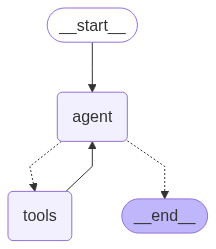

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
from langchain_core.messages import HumanMessage

query = "sguys99@gmail.com으로 Attention Is All You Need 논문을 요약해서 보내주세요 "
for chunk in graph.stream({"messages": [HumanMessage(query)]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

sguys99@gmail.com으로 Attention Is All You Need 논문을 요약해서 보내주세요 
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_jgLdkOqXtg5BYjB8KfyL1Qhl)
 Call ID: call_jgLdkOqXtg5BYjB8KfyL1Qhl
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models. We fin

In [17]:
query = "집이 15억일 때 종합부동산세를 계산해줄 수 있나요?"
for chunk in graph.stream({"messages": [HumanMessage(query)]}, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

집이 15억일 때 종합부동산세를 계산해줄 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_9bdZvSxWIu2kL8iEfLuwPeRl)
 Call ID: call_9bdZvSxWIu2kL8iEfLuwPeRl
  Args:
    query: 15억 주택 종합부동산세 계산
================================= Tool Message =================================
Name: real_estate_tax_retriever


================================== Ai Message ==================================

종합부동산세는 주택의 공시가격, 보유 주택 수, 그리고 각종 세율에 따라 달라집니다. 15억 원의 주택에 대한 정확한 종합부동산세 계산을 위해서는 다음 정보를 추가로 알아야 합니다:

1. 주택의 공시가격
2. 보유하고 있는 다른 주택의 유무
3. 해당 주택의 위치(지방세율 차이)
4. 주택의 용도 (예: 임대주택 등)

이 정보를 바탕으로 세율을 적용해야 정확한 세금을 계산할 수 있습니다. 만약 구체적인 정보가 있다면 알려주시면 더 자세한 계산을 도와드릴 수 있습니다.
